# Filtering, Pathway analysis, and Plots for Inter-Embryo variability

### *Given the dataframes (KLD and null model) from the Inter-Embryo_Divergence_Analysis.ipynb notebook, this notebook creates plots found in figure 2 and in the supplementary information.*

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


from scipy.special import rel_entr, kl_div
from scipy.special import softmax
from scipy.stats import entropy
from scipy import stats


from functools import reduce

In [3]:
import statsmodels.api as sm
import math
import re

In [56]:
import json
import requests

# 1. We calculate the information and perform the processing necessary to filter the KLD dataframe

## 1.1 Prepare the adata object and KLD dataframe to be consistent with further analysis

### We prepare the adata object:
* Choose a single timepoint for the analysis
* Add a timepoint column that converts somites to hours post fertilization (HPF)
* If we want to compute the analysis for the entire embryo, we call the function 'make_columns' with the annotation 'cell_type_1'. Otherwise, we call the function with the desired cell clusters, and the column in which the cell cluster labels can be found
* If the timepoint column in the KLD dataframe has 'hpf' on the end, 'make_timepointHPF_kldf' will remove it and create the timepointHPF column, leaving just the integer so it matches the adata object timepointHPF column

In [4]:
# function: subsets adata for a timepoint
# arguments: adata object and desired timepoint
# output: subset adata object
    
def myadata(adata, timepoint):
    myadata = adata[adata.obs.timepoint == timepoint].copy()
    
    return myadata
    

In [5]:
#function: turn somites into HPF for 'timepointHPF' column
#arguments: adata for a specific timepoint, the timepoint, and list of cell types 
#output: dataframe with gene_mean, fraction_0s columns for each gene/celltype/timepoint

def convertHPF(row):  
    
    if row['timepoint'] == '0 budstage':
        return 10
    elif row['timepoint'] == '05somite':
        return 12
    elif row['timepoint'] == '10somite':
        return 14  
    elif row['timepoint'] == '15somite':
        return 16
    elif row['timepoint'] == '20somite':
        return 19
    elif row['timepoint'] == '30somite':
        return 24
    
    

In [17]:
#function: adds a column to adata object with timepoint in hours post fertilization
#input: adata object
#output: after it is run on the adata object, it now has a column called 'timepoinHPF'

def make_timepointHPF(adata):
    
    adata.obs['timepointHPF'] = adata.obs.apply(lambda row: convertHPF(row), axis=1)

Makes the column with the cell type. Can run either for the whole embryo, as 'cell_type_1', or for a list of specific cell types.

In [6]:
#function: some preprocessing, go from adata object to input for general gene metrics
#input: adata object, and either a list of cell types with the cell type column name, or 'cell_type_1' if whole embryo
#output: adata object with Cells_Annotations column for cell type

def make_columns(adata, annotations = ['cell_type_1'], celltypecolumn = 'ontology_class'):
    
    if annotations[0] == 'cell_type_1':
        newadata = adata.copy()
        newadata.obs['Cells_Annotations'] = 'cell_type_1'
        
    else:
        newadata = adata[adata.obs[celltypecolumn].isin(annotations)].copy()
        newadata.obs['Cells_Annotations'] = newadata.obs[celltypecolumn].copy()
        
    
    return newadata


In [37]:
def make_timepointHPF_kldf(kldf = pd.DataFrame):

    kldf['timepointHPF'] = kldf['timepoint'].str.extract(r'(\d+)').astype(int)

## *Example code:*
* Upload adata object
* Make timepoint column and subset adata object
* Make cell cluster column for desired cell clusters from the cell type column, or run for 'cell_type_1' if doing analysis on the whole embryo
* Now we have our example_adata, ready to run the inter-individual analysis   
* We upload the KLD dataframe, and then run 'make_timepointHPF_kldf' to make sure the KLD dataframe has a matching timepointHPF column to the adata

In [38]:
adata = sc.read_h5ad('/mnt/ibm_lg/alejandro/danio-atlas/atlas_objects/early_timepoints/danio_atlas_umapv2_annotated.h5ad')

In [39]:
example_adata = myadata(adata, '05somite')

In [40]:
make_timepointHPF(example_adata)

In [41]:
example_adata = make_columns(example_adata, ['neural_anterior'], 'annotation_umapv2_global')

In [42]:
example_adata.obs

,orig.ident,X10X_run,fish,fish_n,timepoint,seqrun,cell_annotation,global_annotation,integrated_snn_res.0.5,seurat_clusters,...,leiden_v6_r0.32,leiden_v7_r0.3,leiden_v8_r0.31,leiden_v9_r0.31,leiden_v10_r0.25,leiden_v11_r0.22,leiden_v12_r0.23,annotation_umapv2_global,timepointHPF,Cells_Annotations
TDR35_AACCACACACCTGCAG-1,TDR35,TDR35,TDR35,35,05somite,1,Telencaphalon_Emx3,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior
TDR35_AAGGTAATCAGACAAA-1,TDR35,TDR35,TDR35,35,05somite,1,Telencaphalon_Emx3,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior
TDR35_ACATCGACAACGATTC-1,TDR35,TDR35,TDR35,35,05somite,1,Diencephalon_fezf2,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior
TDR35_ACATGCATCTGCATAG-1,TDR35,TDR35,TDR35,35,05somite,1,OpticPrimardium_rx3,Neural_Anterior,3,3,...,6,1,0,0,1,2,1,neural_anterior,12,neural_anterior
TDR35_ACCAACAAGTGCGTCC-1,TDR35,TDR35,TDR35,35,05somite,1,OpticPrimardium_rx3,Neural_Anterior,3,3,...,6,1,0,0,1,2,1,neural_anterior,12,neural_anterior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TDR38_TTGGGATTCGGTCTGG-1,TDR38,TDR38,TDR38,38,05somite,1,Diencephalon_fezf2,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior
TDR38_TTGTGGAGTGGGCTCT-1,TDR38,TDR38,TDR38,38,05somite,1,Diencephalon_fezf2,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior
TDR38_TTGTGTTAGCGTGTTT-1,TDR38,TDR38,TDR38,38,05somite,1,OpticPrimardium_rx3,Neural_Anterior,3,3,...,20,1,0,0,1,2,1,neural_anterior,12,neural_anterior
TDR38_TTTCAGTAGGAGAGTA-1,TDR38,TDR38,TDR38,38,05somite,1,Diencephalon_fezf2,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior


In [50]:
kldf_example = pd.read_csv('/mnt/ibm_lg/sarah.ancheta/ZF_atlas/intra_inter_v4/periderm_testInter.csv')

In [51]:
make_timepointHPF_kldf(kldf_example)

In [52]:
kldf_example

,Unnamed: 0,gene,cluster,amax,amin,median,std,mean,timepoint,timepointHPF
0,0,dusp16,periderm,0.085622,0.031385,0.051937,0.017558,0.054638,12hpf,12
1,1,crebl2,periderm,0.172862,0.009106,0.065770,0.051778,0.080103,12hpf,12
2,2,tbk1,periderm,0.254781,0.040886,0.098467,0.056874,0.107263,12hpf,12
3,3,eps8a,periderm,0.308331,0.035409,0.108853,0.066193,0.117946,12hpf,12
4,4,ptpro-1,periderm,0.472365,0.027091,0.164663,0.138604,0.202552,12hpf,12
...,...,...,...,...,...,...,...,...,...,...
11000,11000,NC_002333.16,periderm,0.389006,0.046148,0.130883,0.115061,0.172658,12hpf,12
11001,11001,NC_002333.15,periderm,0.330514,0.038421,0.100024,0.096187,0.128745,12hpf,12
11002,11002,mt-nd5,periderm,0.167271,0.027376,0.086407,0.041145,0.092001,12hpf,12
11003,11003,mt-nd6,periderm,0.595210,0.053409,0.163867,0.184375,0.228742,12hpf,12


## 1.2 Calculating general information about each gene for filtering

### We make the intra-gene metrics dataframe to find per-gene cutoffs:
* After running the functions above, the adata object is consistent with further steps
* Get a dataframe with the fraction of 0s and the mean counts for each gene, per cluster 
* We can save this dataframe if desired for further analysis

In [33]:
#function: calculates general information about genes (mean, fraction of zeros)
#arguments: adata for a specific timepoint, the timepoint, and list of cell types 
#output: dataframe with gene_mean, fraction_0s columns for each gene/celltype/timepoint

def getIntraGene_metrics2(bigadata = [[]], annotations = ['cell_type_1']):
    
    myframes = []
    
    for a in annotations:
        
        extra_dict = {}
        
        adata = bigadata[bigadata.obs['Cells_Annotations'] == a].copy()
        mymatrix = adata.X
        
        
        mycounts = adata.X
        mynewcounts = mycounts.toarray()
        mygenes = np.array(adata.var.index.copy())
        extra_dict['gene'] = mygenes
        
    
        # get fraction of 0s
        
        totalcount = len(mynewcounts)
        non0s = np.count_nonzero(mynewcounts, axis=0)
        my0s = (totalcount - non0s)/totalcount
    
        extra_dict['fraction_0s'] = my0s
        
        
        #get mean of gene
        
        mymeans = np.mean(mymatrix, axis=0).flatten().tolist()[0].copy()
        extra_dict['gene_mean'] = mymeans
        
    
        #add timepoint
        
        miniframe = pd.DataFrame(extra_dict)
        miniframe['cluster'] = a
        myframes.append(miniframe)
   
    bigDF = pd.concat(myframes, ignore_index=True)
    
    return bigDF

In [34]:
#function: use this function to calculate the gene metrics for multiple cell types 
#input: the cell types must be in all timepoints in the adata object. adata should be subset for a certain timepoint
#output: returns intra-fish dataframe with timepoint column, for multiple timepoints

def runIntraDF(adata = [[]], annotations = ['cell_type_1']):

    subset_adata = adata[adata.obs['Cells_Annotations'].isin(annotations)].copy()
    
    currdf = getIntraGene_metrics2(subset_adata, annotations)
    currdf['timepointHPF'] = adata.obs.timepointHPF[0]
             
    return currdf
        
        

In [31]:
#function: exports a csv dataframe with KL metrics, per gene, grouped by cell type
#arguments: adata, list of cell types/annotations, out_path as str, title as string 
#output: saves a CSV dataframe with KL metrics per gene, per cell type at the out_path

def saveIntraDf(adata = [], annotations = ['Hindbrain'], out_path = '', save_title = 'date', timepoint = '30'):
    
    
    intra_metrics = getIntraGene_metrics2(adata, timepoint, annotations)
    

    intra_metrics.to_csv(out_path + save_title + 'Intra.csv')
    
    return intra_metrics


## *Example code:*
* Using the example_adata with the processing, we run 'runIntraDF'
* It returns a dataframe with the information needed to filter the KLD dataframe

In [35]:
example_intraDF = runIntraDF(example_adata, ['neural_anterior'])

In [36]:
example_intraDF

,gene,fraction_0s,gene_mean,cluster,timepointHPF
0,ptpn12,0.970888,0.005871,neural_anterior,12
1,phtf2,0.995633,0.001011,neural_anterior,12
2,phtf2-1,0.915575,0.018010,neural_anterior,12
3,CU856344.1,1.000000,0.000000,neural_anterior,12
4,si:zfos-932h1.3,0.938865,0.011613,neural_anterior,12
...,...,...,...,...,...
26147,mt-nd6,0.177584,0.392860,neural_anterior,12
26148,NC-002333.21,0.998544,0.000379,neural_anterior,12
26149,mt-cyb,0.000000,3.950397,neural_anterior,12
26150,NC-002333.22,0.953421,0.008597,neural_anterior,12


## 1.3 We filter the KLD dataframe using information from the intraDF calculated above

### Filtering the KLD dataframe, using the intraDF dataframe we made:
* Remove genes with mean counts less than 0.1
* Remove genes with a fraction of 0s higher than 0.8
* Only keep RNA genes, remove those with type ribosomal or mitochondrial
* We then can choose the top n high and low KLD genes for pathway analysis

In [53]:
#function: filters the KLD df for mean, fraction of 0s and only keep rna genes
#input: KLD df and intra df, both with columns 'gene', 'cluster' and 'timepointHPF'
#output: KLD dataframe with genes that pass the threshold (only rna, other processing)

def gene_types_filter(kldf = pd.DataFrame, intradf = pd.DataFrame):
    
    
    intradf = intradf[(intradf.gene_mean > 0.1) & (intradf.fraction_0s < 0.8)].copy()


    kldf['type'] = 'rna'
    kldf.loc[kldf['gene'].str.startswith('rp'), 'type'] = 'ribo'
    kldf.loc[kldf['gene'].str.startswith('mt-'), 'type'] = 'mito'
    
    bigdf = kldf.merge(intradf, on=['gene','cluster', 'timepointHPF'])

    genes_allrna = bigdf[bigdf.type == 'rna'].copy()
    
    return genes_allrna

In [54]:
#function: defines the top n high and low KLD (kl median) genes 
#input: filtered KLD dataframe, one cluster/cell type of interest, n for number of genes
#output: dataframe with the n high and low genes, with added column 'gene_type' which indicates high/low KL

def lowhighKL_n_genes(df = pd.DataFrame, n = 200, cluster = 'cell_type_1'):
    
    df = df[df.cluster == cluster].copy()
    
    g = df.groupby(["timepointHPF"]).apply(lambda x: x.sort_values(["kl_median"], ascending = False)).reset_index(drop=True)
    # select top N rows within each timepoint (sorted for highest at top)
    g = g.groupby('timepointHPF').head(n).copy()
    g['gene_type'] = 'high-KL'
    
    
    h = df.groupby(["timepointHPF"]).apply(lambda x: x.sort_values(["kl_median"], ascending = True)).reset_index(drop=True)
    # select top N rows within each continent (sorted smallest at top)
    h = h.groupby('timepointHPF').head(n).copy()
    h['gene_type'] = 'low-KL'
    
    genes_rna = pd.concat([h, g], ignore_index = True)
    
    return genes_rna


## *Example code:*
* We take the intradf and KLD dataframe from above, to find the filtered KLD dataframe
* We then take the top 50 genes (with the 50 highest KLD scores and 50 lowest KLD scores, identified in the column 'gene_type' as either 'high-KL' or 'low-KL')

In [236]:
bigdf_rna = gene_types_filter(kldf, intradf)
bigdf_rna

,Unnamed: 0,gene,cluster,kl_amax,kl_amin,kl_median,std,kl_mean,timepointHPF,kl_log2,fraction_0s_x,gene_mean_x,gene_std,type,fraction_0s_y,gene_mean_y
0,4,msgn1,neural_anterior,0.131384,0.023262,0.049207,0.034179,0.059770,12,-4.064441,0.432314,0.182933,0.211550,rna,0.432314,0.182933
1,5,si:ch211-51e12.7,neural_anterior,1.193341,0.059143,0.327692,0.325697,0.373929,12,-1.419163,0.000000,1.797247,0.232920,rna,0.000000,1.797247
2,6,mrps10,neural_anterior,0.558241,0.013300,0.214830,0.154363,0.209599,12,-2.254296,0.033479,0.649810,0.265949,rna,0.033479,0.649810
4,11,xpot,neural_anterior,0.133148,0.022756,0.049089,0.038282,0.058212,12,-4.102530,0.377001,0.196325,0.189667,rna,0.377001,0.196325
5,12,rtcb,neural_anterior,0.283832,0.025127,0.072666,0.069098,0.088047,12,-3.505584,0.553130,0.114329,0.146534,rna,0.553130,0.114329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63632,272664,si:ch211-113a14.24,cell_type_1,0.080188,0.009270,0.036299,0.023523,0.040123,24,-4.783942,0.315859,0.561385,0.529841,rna,0.309706,0.584062
63633,272675,glg1a,cell_type_1,0.070568,0.002844,0.049421,0.019960,0.044772,24,-4.338721,0.526405,0.181543,0.227027,rna,0.507663,0.187610
63634,272682,pdhx,cell_type_1,0.196177,0.007621,0.054800,0.052129,0.069348,24,-4.189673,0.517423,0.183233,0.224770,rna,0.513339,0.180859
63635,272686,ZNF276,cell_type_1,0.069609,0.004683,0.032877,0.020056,0.036067,24,-4.926798,0.668577,0.107682,0.172837,rna,0.667447,0.105759


In [237]:
top_50 = lowhighKL_n_genes(bigdf_rna, 50, 'cell_type_1')
top_50

,Unnamed: 0,gene,cluster,kl_amax,kl_amin,kl_median,std,kl_mean,timepointHPF,kl_log2,fraction_0s_x,gene_mean_x,gene_std,type,fraction_0s_y,gene_mean_y,gene_type
0,185237,zeb2a,cell_type_1,0.013616,0.005475,0.008194,0.002557,0.008661,10,-6.931196,0.288569,0.418598,0.378737,rna,0.310060,0.403106,low-KL
1,185071,cdca7a,cell_type_1,0.012251,0.006180,0.008594,0.001631,0.008792,10,-6.862451,0.101519,0.941997,0.616405,rna,0.104354,0.946082,low-KL
2,183817,nasp,cell_type_1,0.025839,0.006676,0.012207,0.006637,0.013680,10,-6.356135,0.014388,1.391807,0.476055,rna,0.013514,1.398615,low-KL
3,188654,zeb1b,cell_type_1,0.023918,0.007436,0.012329,0.004447,0.013270,10,-6.341845,0.338129,0.395111,0.389132,rna,0.360360,0.378902,low-KL
4,190108,notch1a,cell_type_1,0.043419,0.004560,0.012577,0.015212,0.019559,10,-6.313057,0.058353,0.942120,0.529699,rna,0.082583,0.902583,low-KL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,267812,nme2b.2,cell_type_1,4.947011,0.027884,0.659712,1.668376,1.468009,24,-0.600092,0.634737,0.246156,0.504179,rna,0.633390,0.235462,high-KL
596,269897,tmem38a,cell_type_1,4.507534,0.008406,0.635396,1.595719,1.327645,24,-0.654273,0.719219,0.226650,0.504166,rna,0.738896,0.209486,high-KL
597,260414,zgc:92518,cell_type_1,4.413347,0.025602,0.626132,1.559880,1.321418,24,-0.675460,0.727737,0.232113,0.510467,rna,0.748262,0.213872,high-KL
598,261037,acta1a,cell_type_1,2.406483,0.053379,0.569814,0.890071,0.917527,24,-0.811436,0.479944,0.480431,0.852883,rna,0.512346,0.444454,high-KL


# 2. We conduct Pathway Analysis on the highest and lowest KLD genes

## Filter Mouse Gene Conversion, Get Dictionary

## *** How to include mouse to zebrafish text? Also upload to GitHub? **

In [165]:
mouseGene = pd.read_table('/mnt/ibm_lg/sarah.ancheta/ZF_atlas/Zebrafish_atlas/zf2mouse.txt')

In [166]:
mouseGene['MouseGene'] = mouseGene['Gene2Symbol'].str.lower()
mouseGene['FishGene'] = mouseGene['Gene1Symbol'].str.lower()
genesMulti = (mouseGene['FishGene'].value_counts() > 1)
multiGenes = np.array(genesMulti[genesMulti == True].index)

In [167]:
%%time

for gene in multiGenes:
    specificGene = mouseGene[mouseGene['FishGene'] == gene].reset_index()
    newMouse = specificGene['MouseGene'][0]
    
    mouseGene.loc[mouseGene.FishGene == gene, 'MouseGene'] = newMouse

CPU times: user 5.16 s, sys: 1.23 ms, total: 5.16 s
Wall time: 5.16 s


The mouseGene table has been fixed, so every zebrafish gene has exactly one specific mouse gene.

In [168]:
newMouseGene = mouseGene.copy()
specificGene = mouseGene[mouseGene['FishGene'] == multiGenes[0]].reset_index()
zebra_mouse = dict(zip(newMouseGene.FishGene, newMouseGene.MouseGene))

In [169]:
lib_try = ['BioCarta_2016', 'GO_Biological_Process_2021', 'KEGG_2019_Mouse', 
             'Mouse_Gene_Atlas', 'Panther_2016', 'Reactome_2022', 'Reactome_2016', 
             'WikiPathways_2019_Mouse']

### We have defined out zebrafish/mouse dictionary, and specified the databases we want to use in our library for Enrichr analysis

## Getting the cluster pathway analysis from the dataframe

In [170]:
#function: converts list of fish genes to mouse, and then calls enrichr
#input: list of fish genes and library (list of databases)
#output: dataframe with rows for different pathways found in different libraries

def getframe_fishgenes(mygenes = ['sox2'], mylibrary = ['KEGG_2015']):
    
    df = pd.DataFrame.from_dict({'genes': mygenes})
    mouselist = fish_tomouse_gene_enrichr(df['genes']).tolist()
    

    return gene_enrichr(mouselist, description = 'Example gene list', all_gene_set_library = mylibrary)
    

In [171]:
#function: maps zebrafish genes to mouse genes
#input: list of lowercase zebrafish genes
#output: list of uppercase mouse genes, remove NaNs

def fish_tomouse_gene_enrichr(fishgene = ['PHF14', 'RBM3', 'MSL1']):
    
    mouse_genes = fishgene.map(zebra_mouse)
    my_genes = mouse_genes.copy().dropna()
    my_genes = my_genes.str.upper().values
    
    
    return my_genes

In [172]:
#function: uses Enrichr to compute pathways on the given list of genes for each database
#input: takes in a list with converted fish (mouse) genes, a description and a library of gene databases
#output: dataframe with rows for different pathways, found in different libraries

def gene_enrichr(genelist = ['PHF14', 'RBM3', 'MSL1'], description = 'Example gene list', all_gene_set_library = ['KEGG_2015']):
    
    mySets_DFs = []
    my_ID = get_enrichrID(genelist, description)
    
    for gene_set in all_gene_set_library:
        
        mydata = get_enrichrData(my_ID, gene_set)
        miniDF = createDF_enrichr(mydata)
        miniDF['database'] = gene_set
        
        mySets_DFs.append(miniDF)
        
        
    bigpathway_DF = pd.concat(mySets_DFs, axis=0, ignore_index=True)
    
    return bigpathway_DF
    
    





In [173]:
#function: analyzes gene list
#input: list of mouse genes and description of gene list
#output: returns ID for Enrichr search

def get_enrichrID(genelist = ['PHF14', 'RBM3', 'MSL1'], description = 'Example gene list'):
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(genelist)
    description = description
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')

    data1 = json.loads(response.text)
    return data1['userListId']

In [174]:
#function: gets pathway enrichment information 
#input: ID for Enrichr search (of gene list) and the gene database
#output: data for pathway enrichment dataframe

def get_enrichrData(myuserID = 52026948, gene_set_library = 'KEGG_2015'):

    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    user_list_id = myuserID
    response = requests.get(
        ENRICHR_URL + query_string % (user_list_id, gene_set_library)
     )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    data = json.loads(response.text)
    return data

In [175]:
#function: takes subset of pathway enrichment data and makes a dataframe
#input: data from Enrichr search
#output: dataframe with pathway enrichment information

def createDF_enrichr(data = {}):
    
    column_names = ['Rank', 'pathway', 'P_value', 'Z_score', 'Combined_score', 'Overlapping_genes', 'Adjusted_pval', 'Old_pval', 'Old_adjusted_pval']
    alldfs = []
    
    for key in data.keys():
        
        data_list = data.get(key).copy()
        data_list.insert(0, column_names)
    
        keyDF = pd.DataFrame(data_list[1:],columns=data_list[0])
        alldfs.append(keyDF)
    
    return pd.concat(alldfs, ignore_index=True)     

# Pathway analysis on high/low KL genes

In [176]:
#function: gets pathway dataframe for visualization, does pathway analysis
#input: dataframe with low/high KL n genes (only one cluster/celltype)
#output: pathway analysis dataframe

def pathwaysforvariable_geneDFs(topvariablegenes = pd.DataFrame):
    mytime = topvariablegenes.timepointHPF.unique()

    myhighdfs = []
    mylowdfs = []

    for time in mytime:

        timest = str(time)

        highdf = topvariablegenes[(topvariablegenes['timepointHPF'] == time) & (topvariablegenes['gene_type'] == 'high-KL')]
        pathwayshigh = getframe_fishgenes(highdf['gene'], lib_try)
        pathwayshigh['timepoint'] = time
        myhighdfs.append(pathwayshigh)

        lowdf = topvariablegenes[(topvariablegenes['timepointHPF'] == time) & (topvariablegenes['gene_type'] == 'low-KL')]
        pathwayslow = getframe_fishgenes(lowdf['gene'], lib_try)
        pathwayslow['timepoint'] = time
        mylowdfs.append(pathwayslow)
      
    highinter_pathways = pd.concat(myhighdfs, ignore_index=True)
    highinter_pathways['gene_type'] = 'high_inter-fish'
    lowinter_pathways = pd.concat(mylowdfs, ignore_index=True)
    lowinter_pathways['gene_type'] = 'low_inter-fish'
    
    bigframe = pd.concat([highinter_pathways, lowinter_pathways], ignore_index=True)
    
    return bigframe
    

In [238]:
pathwaysforvariable_geneDFs(top_50)

,Rank,pathway,P_value,Z_score,Combined_score,Overlapping_genes,Adjusted_pval,Old_pval,Old_adjusted_pval,database,timepoint,gene_type
0,1,Angiotensin II mediated activation of JNK Path...,0.001348,41.533333,274.513655,"[PAK1, FOS]",0.048511,0,0,BioCarta_2016,10,high_inter-fish
1,2,MAPKinase Signaling Pathway Homo sapiens h map...,0.003619,24.585185,138.207732,"[PAK1, FOS]",0.061205,0,0,BioCarta_2016,10,high_inter-fish
2,3,TSP-1 Induced Apoptosis in Microvascular Endot...,0.011148,107.322581,482.576064,[FOS],0.061205,0,0,BioCarta_2016,10,high_inter-fish
3,4,Pertussis toxin-insensitive CCR5 Signaling in ...,0.014311,80.483871,341.793569,[FOS],0.061205,0,0,BioCarta_2016,10,high_inter-fish
4,5,IL 3 signaling pathway Homo sapiens h il3Pathway,0.019037,58.524927,231.838999,[FOS],0.061205,0,0,BioCarta_2016,10,high_inter-fish
...,...,...,...,...,...,...,...,...,...,...,...,...
12218,11,Myometrial Relaxation and Contraction Pathways...,0.292456,2.960975,3.640348,[GNB1],0.374467,0,0,WikiPathways_2019_Mouse,24,low_inter-fish
12219,12,Insulin Signaling WP65,0.302028,2.847670,3.409332,[XBP1],0.374467,0,0,WikiPathways_2019_Mouse,24,low_inter-fish
12220,13,TNF-alpha NF-kB Signaling Pathway WP246,0.345050,2.415567,2.570322,[CSNK2A1],0.374467,0,0,WikiPathways_2019_Mouse,24,low_inter-fish
12221,14,Chemokine signaling pathway WP2292,0.349503,2.376864,2.498664,[GNB1],0.374467,0,0,WikiPathways_2019_Mouse,24,low_inter-fish


# Visualization code

## gene example distributions

In [178]:
#function: returns a dataframe with columns counts, and the cluster label (does it for each gene)
#inputs: adata object, cluster column, specific gene, type of counts (all are log)
#output: dataframe with a column of counts and the label (which fish)


def singlegenebycluster(adata, obs_column, gene, layer = 'scaled'):
    myclusters = adata.obs[obs_column].unique().sort_values()
    fulldata = pd.DataFrame(columns=['counts', 'cluster'])
    cluster_dfs = []
    for i in myclusters:
        adata_filter = adata[adata.obs[obs_column] == i].copy()
        myindex = adata_filter.var.index.get_loc(gene)
        
        if (layer == 'scaled'):
            mycounts = adata_filter.X[:, myindex].toarray()
            
        if (layer == 'log'):
            mycounts = adata_filter.raw.X[:, myindex].toarray()
            
        if (layer == 'counts'):
            mycounts1 = adata_filter.layers['counts'].toarray()
            mycounts = mycounts1[:, myindex]
 
        minidata = pd.DataFrame(mycounts, columns=['counts']).copy()
        minidata['cluster'] = i
        cluster_dfs.append(minidata)
    fulldata = pd.concat(cluster_dfs, ignore_index=True)
    
    return fulldata

In [179]:
#function: creates a dataframe for use in density plot, with counts, fish information and gene
#inputs: adata, column to separate (fish n), list of genes (str) and layer
#output: dataframe with counts, column info (fish) and gene

def countsbycluster(adata, obs_column, genes, layer = 'scaled'):
    bigframe = pd.DataFrame(columns = ['gene','counts', 'cluster'])
    gene_dfs = []
    for g in genes:
        geneframe = singlegenebycluster(adata, obs_column, g, layer)
        geneframe['gene'] = g
        gene_dfs.append(geneframe)
    bigframe = pd.concat(gene_dfs, ignore_index=True)
    return bigframe

In [180]:
#function: creates a density plot with RNA counts for a set of specific genes, for a particular cell type, separated by fish
#inputs: adata object, cell type, list of genes (str)
#output: graph comparing genes, different distributions colored by fish

def densityPlotCompareGenesbyFish(adata = [], cluster = 'Hindbrain', genes  = ['ndufb2', 'rps16'], large=6):
    
    myadata = adata[adata.obs['Cells_Annotations'] == cluster]
    comparetop = countsbycluster(myadata, 'fish', genes, 'scaled')
    
    f = plt.figure(figsize=(12,8))
    g = sns.FacetGrid(comparetop, hue = "cluster", row="gene",
                  height=3, aspect=4,)


    g.set(xlim=(-0.5, large))

    g.set_axis_labels("Log RNA Counts", "Fraction Cells")

    sns.set(font_scale=2, style='white')

    g.map(sns.kdeplot, "counts")
    g.add_legend()
    
    return g
    
    #plt.show()
    
    #g.savefig("examplegenes_KL.pdf", bbox_inches='tight')
    

In [181]:
#function: plots individual genes colored by fish
#input: adata for one timepoint, cell type/cluster as 'Cells_Annotations', list of genes, and max value of counts 'large'
#output: plot with multiple rows, each is one gene

def plotGenes(adata = [], cluster = 'Hindbrain', genes = [], large=6):
    
    
    myadata = adata.copy()
    
    if 'Cells_Annotations' in adata.obs.columns:
            None
    
    elif cluster == 'whole_embryo':
        adata.obs['Cells_Annotations'] = 'whole_embryo'
        
    else:
        adata.obs = adata.obs.rename(columns={"zebrafish_anatomy_ontology_class": "Cells_Annotations"})
     
        
    return densityPlotCompareGenesbyFish(myadata, cluster, genes, large)
    

## heatmap of KL

In [182]:
#function: makes a matrix with the pairwise KL values
#arguments: takes in a matrix of counts (sparse), a gene, cell type, list of fish (str), layer (log/scaled str), obs and var from adata as pd.DF
#output: a matrix with all pairwise KL scores for the fish

def kl_fish_matrix2(matrix = [[],[]], gene = 'phtf2', cluster = 'Somite', fish = [], layer = 'log', obs =pd.DataFrame, var=pd.DataFrame):

    fishcols = []
    
    for f1 in fish:
        f1row = []
        for f2 in fish:
            value = kl_fishpair_genecelltype2(matrix, gene, cluster, f1, f2, layer, obs, var)
            #print(value)
            if (value == -1):
                return -1
            f1row.append(value)
        fishcols.append(f1row)      

    return fishcols 

In [183]:
#function: helper to make the matrix, gets the specific arrays and sends to kl function
#arguments: matrix of counts (sparse), gene, cell type, two fish (str), layer (log/scaled str), obs and var from adata as pd.DF
#output: kl divergence score for two arrays (calls kl function)

def kl_fishpair_genecelltype2(matrix = [[],[]], gene = 'phtf2', cluster = 'Somite', fish1 = '44', fish2 = '46', layer = 'log', obs=pd.DataFrame, var=pd.DataFrame):    
    
    row1 = obs['fish'].loc[lambda x: x==fish1].index.tolist()
    row2 = obs['fish'].loc[lambda x: x==fish2].index.tolist()
    
    myindex = int(var.index[var['index']==gene].tolist()[0])
    
    if (layer == 'scaled'):
        q = np.asarray(matrix[row1, myindex]).flatten()
        p = np.asarray(matrix[row2, myindex]).flatten()
    
    if (layer == 'log'):
        q = np.asarray(matrix.tocsr()[row1, myindex].todense()).flatten()
        p = np.asarray(matrix.tocsr()[row2, myindex].todense()).flatten()
    
    ##check
    if (layer == 'counts'):
        mymatrix = myadata.layers.copy()
    
    if (np.sum(p > 0) < 10) or (np.sum(q > 0) < 10):
        return -1
    else:
        return kl_divergence(q, p)

In [184]:
#function: calculation of KL for two numpy arrays
#arguments: two numpy arrays
#output: KL score (float)

def kl_divergence(fish1gene = [],  fish2gene = []):
    
    
    pkde = stats.gaussian_kde(np.array(fish1gene))
    qkde = stats.gaussian_kde(np.array(fish2gene))
    maxval = np.max([np.max(fish1gene), np.max(fish2gene)])
    minval = np.min([np.min(fish1gene), np.min(fish2gene)])
    
    ### check gaussian_kde, no parameter that could change results (ie. range)
    offset = 1
    newx = np.linspace(minval-offset, maxval+offset,1000)
    
    p = pkde.pdf(newx)
    q = qkde.pdf(newx)
    
    newp = np.where(p< 1e-9, 1e-9, p)
    newq = np.where(q< 1e-9, 1e-9, q)

    
    kl_pair = stats.entropy(newp, newq)
    return kl_pair

In [185]:
#function: gets the matrix of pairwise KLD values
#input: adata for a single timepoint, cluster (cell type) as Cells Annotations, specific gene
#output: numpy matrix of KLD values

def make_kl_fishmatrix(adata, cluster, gene):
    
    mymatrix = adata.X.copy()
    
    if 'Cells_Annotations' in adata.obs.columns:
        None
    
    elif cluster == 'whole_embryo':
        adata.obs['Cells_Annotations'] = 'whole_embryo'
        
    else:
        adata.obs = adata.obs.rename(columns={"zebrafish_anatomy_ontology_class": "Cells_Annotations"})
     
    myobs = adata.obs.copy().reset_index()
    myvar = adata.var.copy().reset_index()
    mygene = gene
    mycluster = cluster
    myfish = adata.obs.fish.unique()
    
    
    
    my_matrix = kl_fish_matrix2(mymatrix, mygene, mycluster, myfish, 'log', myobs, myvar)
    
    return my_matrix
    

In [186]:
#function: creates a heatmap 
#input: adata for a single timepoint, cluster (Cells_Annotations), gene, minimum KLD value, max KLD value (set for heatmap)
#output: heatmap plot of pairwise KLD values

def make_kl_heatmap(adata, cluster, gene, mymin = 0, mymax = 20):
    
    mymatrix = make_kl_fishmatrix(adata, cluster, gene)
    
    greyscale = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
    
    sns.heatmap(mymatrix, vmin = mymin, vmax = mymax, cmap = greyscale)
    

# Multiplot code, combine genes and heatmap

## Fish palette colors, specify colors for each fish label

In [187]:
myfishpalette = {'TDR35': 'orchid', 'TDR36': 'orange', 'TDR37': 'olivedrab', 'TDR38': 'steelblue'}

### UMAP colored by fish

In [188]:
adata_12hpf = timepoint_adata(adata, 12)

/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:355: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


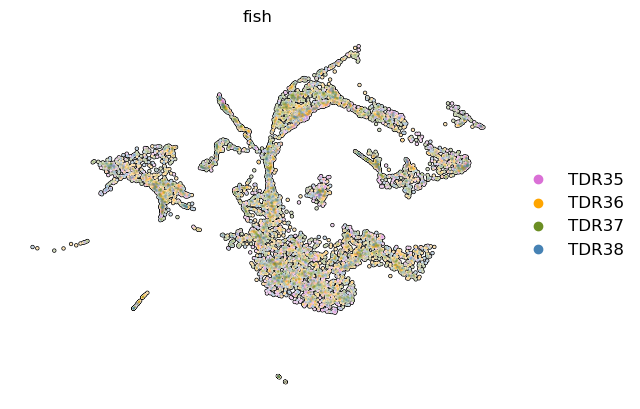

In [190]:
## input adata is a specific timepoint, with the umap already created


sc.pl.umap(adata_12hpf, color="fish", add_outline=True, 
           legend_fontsize=12, legend_fontoutline=2,
           frameon=False, size=13, palette=myfishpalette, alpha=0.3,
          #save='umap_coloredbyfish_timepointspecific_12hpf_v.pdf'
          )

#fig.savefig('/mnt/ibm_lg/sarah.ancheta/ZF_atlas/inter_plots/umap_coloredbyfish_timepointspecific_12hpf.pdf', bbox_inches='tight')
#fig.show()

In [259]:
#function: multiplot of UMAP, histogram colored by fish next to heatmap of pairwise KLD scores between fish (for 2 genes)
#arguments: adata for single timepoint, adata with UMAP, two genes, cell type, min and max on histogram x-axis, title of plot
#output: figure with subplots

def makefigure(curradata= [[]], adataumap = [[]], gene1 = 'ptpn12', gene2 = 'lrp6', celltype = 'cell_type_1', distxmin=-0.1, distxmax=0.4, mytitle = 'gene_comparison_plot'):
    
    comparetop = countsbycluster(curradata, 'fish', [gene1, gene2], 'scaled')
    mymatrix_gene1 = make_kl_fishmatrix(curradata, celltype, gene1)
    mymatrix_gene2 = make_kl_fishmatrix(curradata, celltype, gene2)
    
    heatmax = np.max([np.max(mymatrix_gene1), np.max(mymatrix_gene2)]) + 0.02
    
    myfish = curradata.obs.fish.unique()
    
    
    myfishpalette = {myfish[0]: 'orchid', myfish[1]: 'orange', myfish[2]: 'olivedrab', myfish[3]: 'steelblue'}
    fig = plt.figure(figsize=(10, 5), constrained_layout=True)
    subfigs = fig.subfigures(2,1, wspace=0)
    sns.set_style("white")
    

    greyscale = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0)


    axestop = subfigs[0].subplots(1,4)
    axes1 = subfigs[1].subplots(1, 4)

    gs = axestop[0].get_gridspec() #Get gridspecs
    for i in range(4):

        axestop[i].remove()


    umap1 = subfigs[0].add_subplot(gs[0:1, 0:1])
    genecomp1 = subfigs[0].add_subplot(gs[0:1, 1:3])
    heatgene1 = subfigs[0].add_subplot(gs[0:1, 3:4])


    sc.pl.umap(curradata, color="fish", show=False, size=13, ax=umap1, palette=myfishpalette, legend_loc=None, alpha=0.3)

    sns.kdeplot(data=comparetop[comparetop.gene == gene1], x="counts", common_norm=False, legend=False, palette=myfishpalette, hue='cluster', ax=genecomp1).set(title=gene1)

    genecomp1.axis(xmin=distxmin,xmax=distxmax, ymin=0, ymax=3)
    #genecomp1.set_xlabel('Normalized Expression')
    #genecomp1.set_ylabel('Fraction of Cells')


    sns.heatmap(mymatrix_gene1, vmin = 0, vmax = heatmax, cmap = greyscale, square=True, ax=heatgene1)
    #heatgene2.axis('off')


    gs2 = axes1[0].get_gridspec() #Get gridspecs
    for i in range(4):

        axes1[i].remove()


    umap2 = subfigs[1].add_subplot(gs2[0:1, 0:1])
    genecomp2 = subfigs[1].add_subplot(gs2[0:1, 1:3])
    heatgene2 = subfigs[1].add_subplot(gs2[0:1, 3:4])


    sns.kdeplot(data=comparetop[comparetop.gene == gene2], x="counts", hue='cluster', legend=False, palette=myfishpalette, common_norm=False, ax=genecomp2).set(title=gene2)
    genecomp2.axis(xmin=distxmin,xmax=distxmax, ymin=0, ymax=3)


    sns.heatmap(mymatrix_gene2, vmin = 0, vmax = heatmax, cmap = greyscale, square=True, ax=heatgene2)
    heatgene2.axis('off')
    
    #fig.savefig('/mnt/ibm_lg/sarah.ancheta/ZF_atlas/inter_plots/geneexamples_' + mytitle + '.pdf', bbox_inches='tight')
    
    

/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


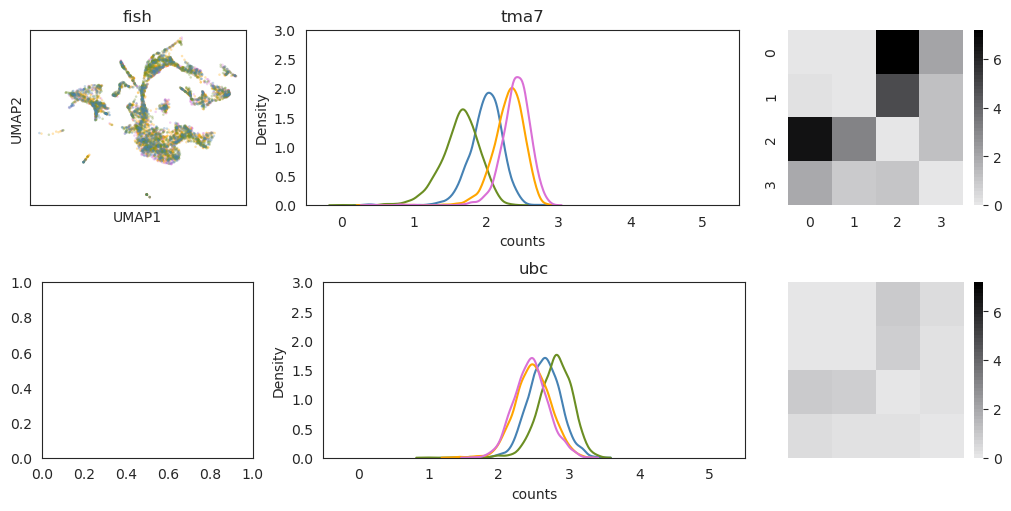

In [196]:
makefigure(adata_12hpf, adata_12hpf, 'tma7', 'ubc', 'cell_type_1', -0.5, 5.5, 'tma7_ubc_whole_embryo_genecomparison_12hpf')

/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems

<Figure size 1200x800 with 0 Axes>

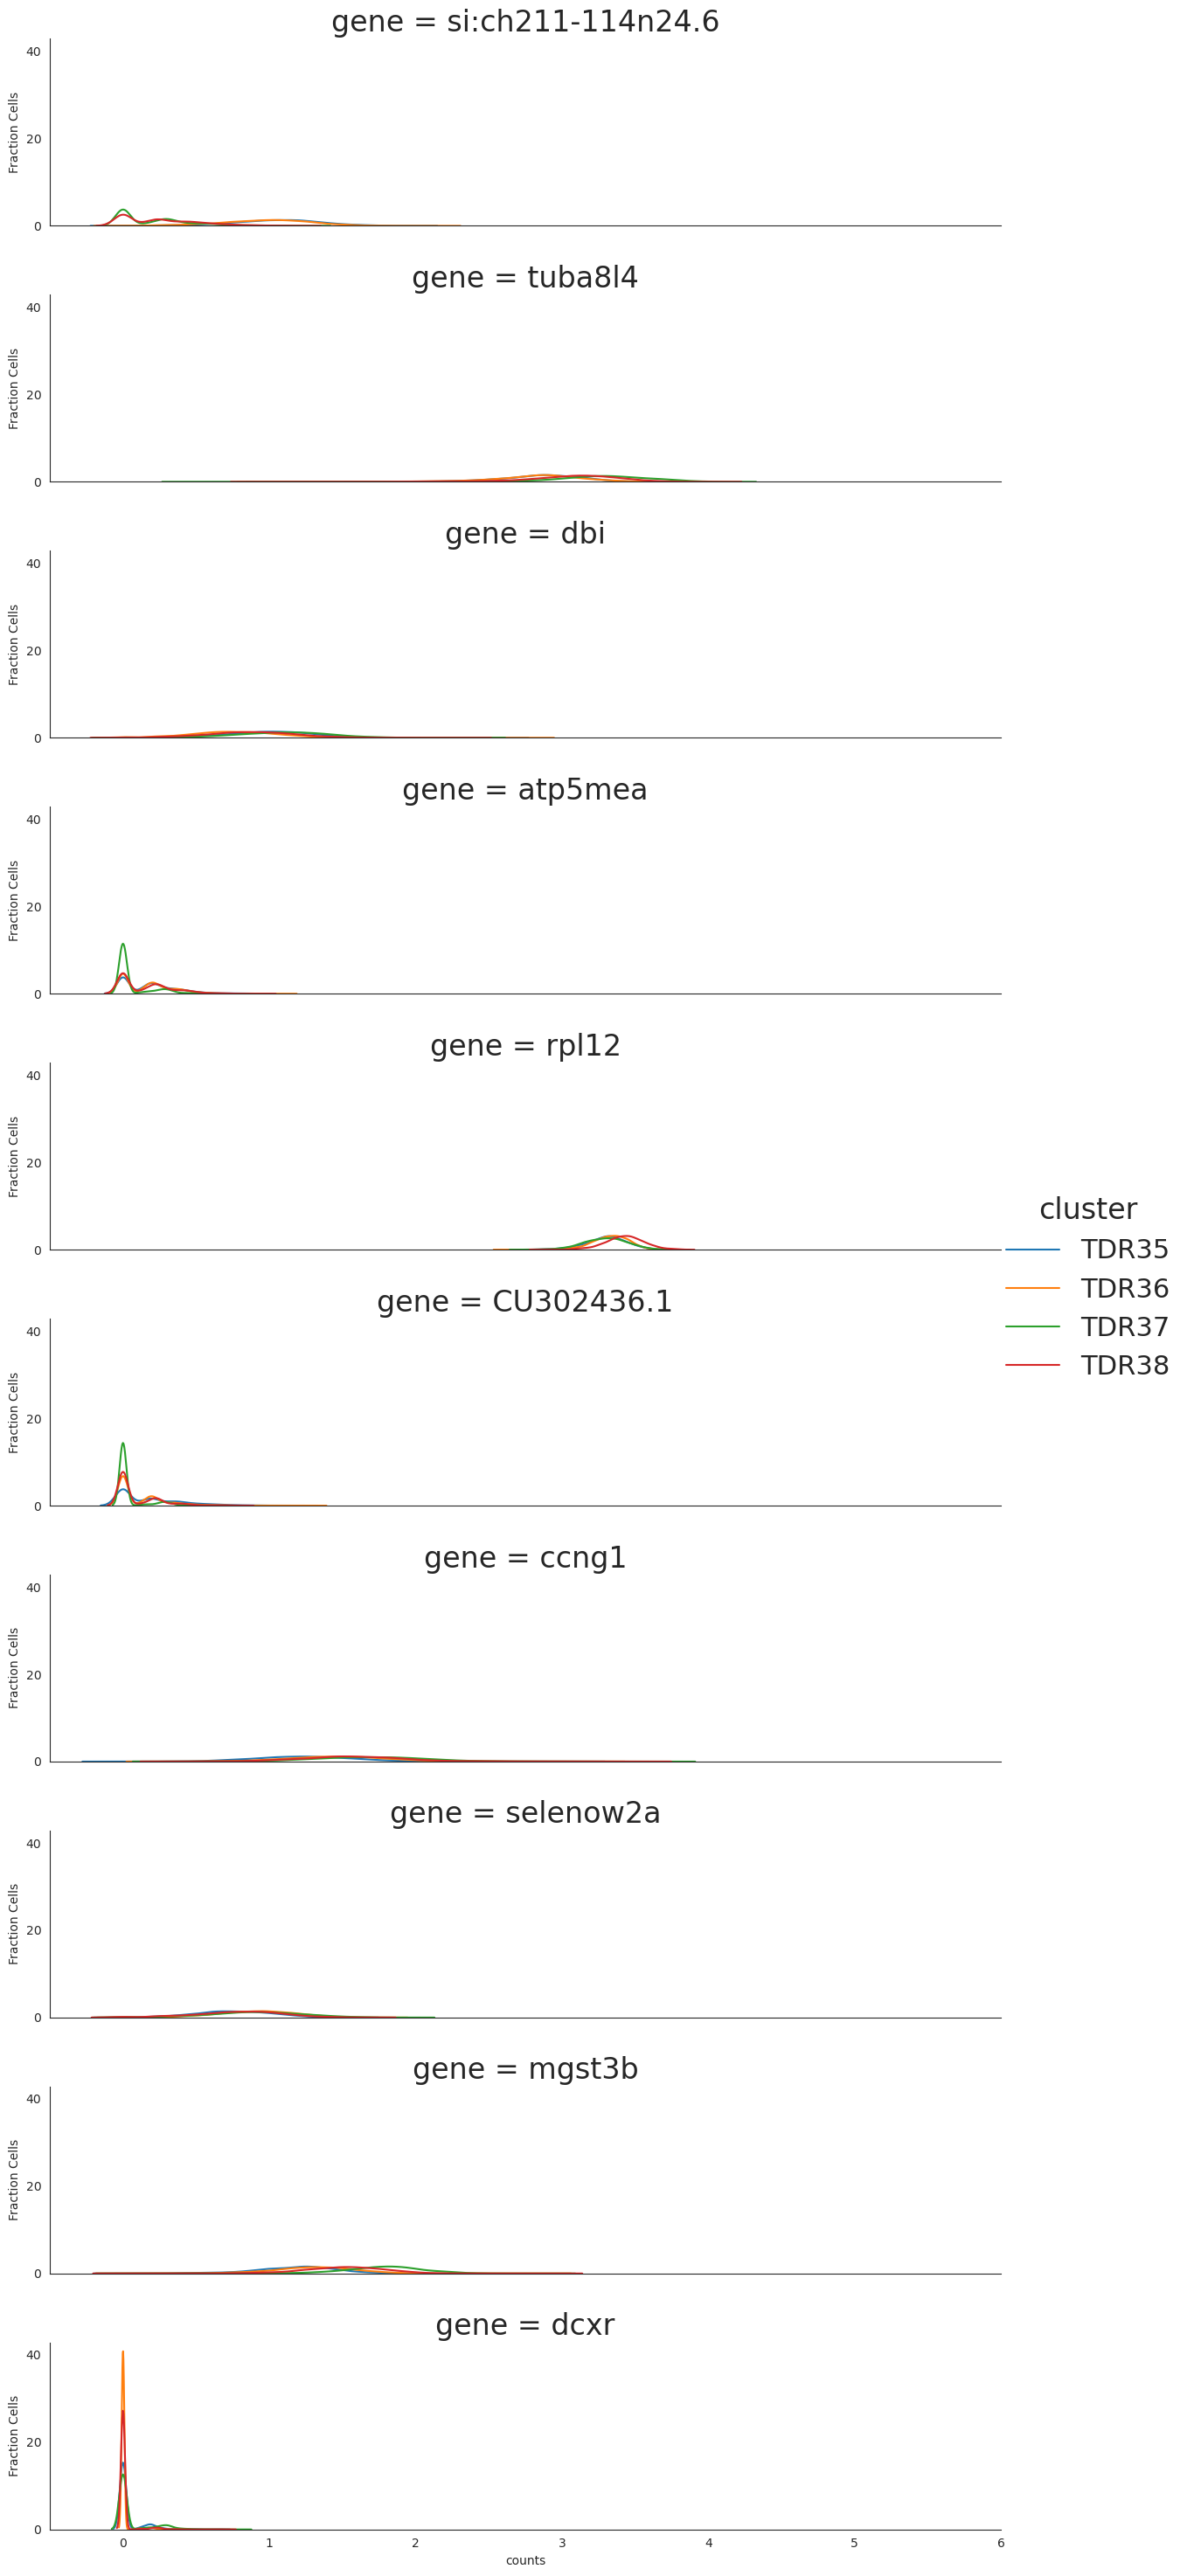

In [197]:
densityPlotCompareGenesbyFish(adata_12hpf, 'cell_type_1', genes = ['si:ch211-114n24.6',
 'tuba8l4',
 'dbi',
 'atp5mea',
 'rpl12',
 'CU302436.1',
 'ccng1',
 'selenow2a',
 'mgst3b',
 'dcxr'], large=6)

# Over time clusters ** fix and find code **

In [239]:
bigdf_rna

,Unnamed: 0,gene,cluster,kl_amax,kl_amin,kl_median,std,kl_mean,timepointHPF,kl_log2,fraction_0s_x,gene_mean_x,gene_std,type,fraction_0s_y,gene_mean_y
0,4,msgn1,neural_anterior,0.131384,0.023262,0.049207,0.034179,0.059770,12,-4.064441,0.432314,0.182933,0.211550,rna,0.432314,0.182933
1,5,si:ch211-51e12.7,neural_anterior,1.193341,0.059143,0.327692,0.325697,0.373929,12,-1.419163,0.000000,1.797247,0.232920,rna,0.000000,1.797247
2,6,mrps10,neural_anterior,0.558241,0.013300,0.214830,0.154363,0.209599,12,-2.254296,0.033479,0.649810,0.265949,rna,0.033479,0.649810
4,11,xpot,neural_anterior,0.133148,0.022756,0.049089,0.038282,0.058212,12,-4.102530,0.377001,0.196325,0.189667,rna,0.377001,0.196325
5,12,rtcb,neural_anterior,0.283832,0.025127,0.072666,0.069098,0.088047,12,-3.505584,0.553130,0.114329,0.146534,rna,0.553130,0.114329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63632,272664,si:ch211-113a14.24,cell_type_1,0.080188,0.009270,0.036299,0.023523,0.040123,24,-4.783942,0.315859,0.561385,0.529841,rna,0.309706,0.584062
63633,272675,glg1a,cell_type_1,0.070568,0.002844,0.049421,0.019960,0.044772,24,-4.338721,0.526405,0.181543,0.227027,rna,0.507663,0.187610
63634,272682,pdhx,cell_type_1,0.196177,0.007621,0.054800,0.052129,0.069348,24,-4.189673,0.517423,0.183233,0.224770,rna,0.513339,0.180859
63635,272686,ZNF276,cell_type_1,0.069609,0.004683,0.032877,0.020056,0.036067,24,-4.926798,0.668577,0.107682,0.172837,rna,0.667447,0.105759


<AxesSubplot: xlabel='timepointHPF', ylabel='kl_log2'>

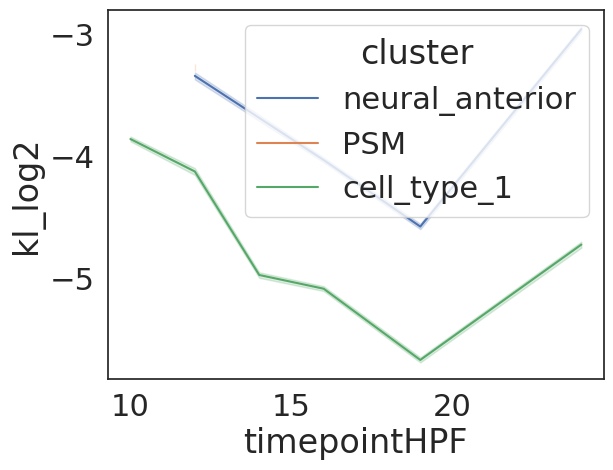

In [243]:
sns.lineplot(data=bigdf_rna, 
             x= 'timepointHPF', y="kl_log2", hue = 'cluster')

## Kolmogorov–Smirnov test between adjacent timepoints

In [662]:
full_we_1 = full_we[full_we.timepointHPF == 12].copy()
full_we_2 = full_we[full_we.timepointHPF == 14].copy()

stats.ks_2samp(full_we_1['kl_median'], full_we_2['kl_median'])

KstestResult(statistic=0.42567816021470645, pvalue=0.0)

In [664]:
full_we_1 = full_we[full_we.timepointHPF == 14].copy()
full_we_2 = full_we[full_we.timepointHPF == 16].copy()

stats.ks_2samp(full_we_1['kl_median'], full_we_2['kl_median'])

KstestResult(statistic=0.07884998467976952, pvalue=6.238802014896042e-17)

In [665]:
full_we_1 = full_we[full_we.timepointHPF == 16].copy()
full_we_2 = full_we[full_we.timepointHPF == 19].copy()

stats.ks_2samp(full_we_1['kl_median'], full_we_2['kl_median'])

KstestResult(statistic=0.3491064385898334, pvalue=2.065e-321)

In [666]:
full_we_1 = full_we[full_we.timepointHPF == 19].copy()
full_we_2 = full_we[full_we.timepointHPF == 24].copy()

stats.ks_2samp(full_we_1['kl_median'], full_we_2['kl_median'])

KstestResult(statistic=0.500351954735841, pvalue=0.0)

# Supplementary

## Making Null Distribution Plots for supplementary

In [203]:
#function: returns dataframe with z-scores, calculated for each gene. z-scores are capped are the max threshold
#input: scrambled/null KLD dataframe, original KLD dataframe, (both for one timepoint) z-score threshold (to cap)
#output: z-score dataframe

def get_zscore_scrambleDF(nulldf = pd.DataFrame, original = pd.DataFrame, threshold = 10):
    
    df1 = nulldf.groupby(['gene'])['median'].agg('mean').to_frame().rename(columns={'median':'scramble_mean'})
    df2 = nulldf.groupby(['gene'])['median'].agg('std').to_frame().rename(columns={'median': 'scramble_sd'})
    df3 = original[['gene', 'kl_median']].set_index('gene')
    
    combodf = pd.concat([df1, df2, df3], axis = 1, join = 'inner')
    combodf['z-score'] = ((combodf['kl_median'] - combodf['scramble_mean'])/combodf['scramble_sd'])
    
    combodf['over10_zscore'] = combodf['z-score'].copy()
    combodf['over10_zscore'].where(combodf['over10_zscore'] <= threshold, threshold, inplace=True)
    
    return combodf
    

In [262]:
#function: multiplot with the original/null histograms, z-score vs KLD score, bar plot of z-score values (# of genes)
#input: original KLD dataframe, null/scramble KLD dataframe for one celltype/timepoint, cell type, timepoint, max z-score, plot title 
#output:

def allscramble_nullplots(bigDF = pd.DataFrame, scrambleDF = pd.DataFrame, cluster='PSM', timepoint=12, threshold=10, mytitle='mytitle'):   
    
    fig = plt.figure(figsize=(10, 3), constrained_layout=True)
    subfigs = fig.subfigures(1,1, wspace=0)


    axestop = subfigs.subplots(1,3)

    gs = axestop[0].get_gridspec() #Get gridspecs
    for i in range(3):

        axestop[i].remove()


    null_originaldist = subfigs.add_subplot(gs[0:1, 0:1])
    zscorescatter = subfigs.add_subplot(gs[0:1, 1:2])
    zscoredist = subfigs.add_subplot(gs[0:1, 2:3])



    miniDF = bigDF[(bigDF.cluster == cluster) & (bigDF.timepointHPF == timepoint)].copy()
    myzs = get_zscore_scrambleDF(scrambleDF, miniDF, threshold)
    zscoredist.hist(myzs['over10_zscore'], 15)
    zscoredist.set_xlabel('z-score, set values above to ' + str(threshold))
    zscoredist.set_ylabel('Number of Genes')



    null_originaldist.hist(miniDF['kl_log2'], 30, density=True, alpha =0.5, color='blue', label='Original Data')
    null_originaldist.hist(scrambleDF['kl_log2'], 30, density=True, alpha=0.5, color='red', label='Negative Control')
    null_originaldist.legend(loc=1, prop={'size': 8})
    null_originaldist.set_xlabel('Inter-fish Diveristy (KL log2)')
    null_originaldist.set_ylabel('Density')

    
    mytitle = cluster+'_'+str(timepoint)+'_hpf'

    sns.scatterplot(data=myzs, x='z-score', y='kl_median', ax=zscorescatter).set(title=mytitle) 
    
    fig.savefig('/mnt/ibm_lg/sarah.ancheta/ZF_atlas/inter_plots/nulldistribution_plots_' + mytitle + '.pdf', bbox_inches='tight')
    

    plt.show()





In [245]:
psm_scramble = pd.read_csv('/mnt/ibm_lg/sarah.ancheta/ZF_atlas/intra_inter_v4/psm_12hpf_Dec2null_scramble.csv')

In [248]:
psm_scramble['kl_log2'] = np.log2(psm_scramble['median'].copy())

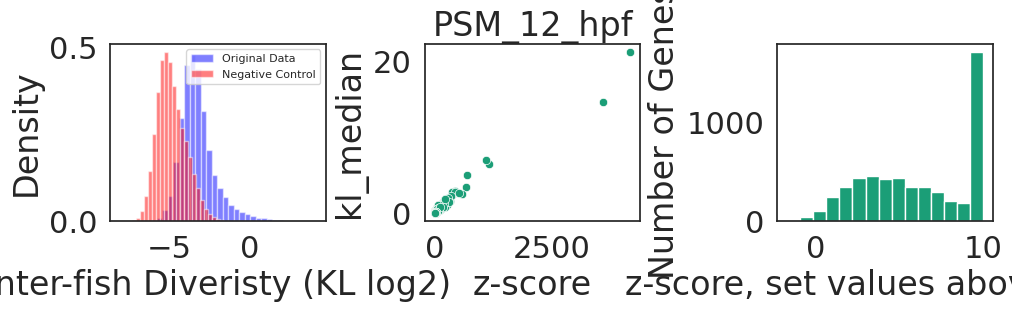

In [263]:
allscramble_nullplots(bigdf_rna, psm_scramble, 'PSM', 12, 10, 'psm_12hpf')